In [1]:
import glob

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u

import emcee

from dust_extinction.averages import G03_SMCBar
from dust_extinction.parameter_averages import G23

from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

Specify the location of the model and observed data

In [2]:
file_path = "/home/kgordon/Python/extstar_data/"

Define star specific parameters

In [4]:
starname = "2massj150958"
fstarname = f"{starname}.dat"
velocity = 350. # MW radial velocity from NED
relband = "V"

Read in the star data

In [5]:
# get the observed reddened star data
reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
band_names = reddened_star.data["BAND"].get_band_names()
data_names = reddened_star.data.keys()

print(band_names)
print(data_names)

# remove data below 1300 A - very noisy
# bvals = reddened_star.data["STIS"].waves < 0.13 * u.micron
# reddened_star.data["STIS"].fluxes[bvals] = 0.0
# reddened_star.data["STIS"].npts[bvals] = 0

# print(max(reddened_star.data["MIRI_IFU"].fluxes))

['B', 'V', 'J', 'H', 'K']
dict_keys(['BAND', 'STIS_Opt', 'STIS'])


Plot the spectrum

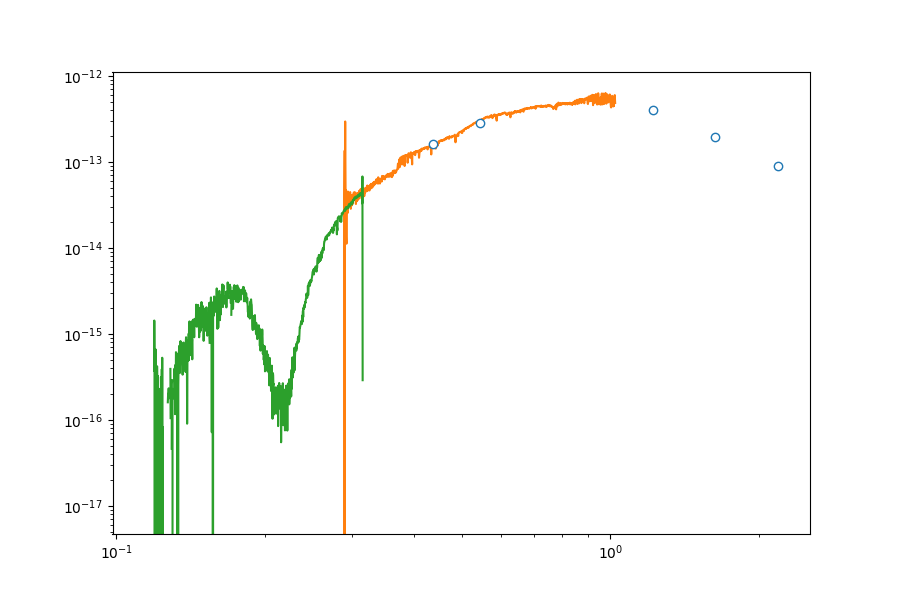

In [6]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(9, 6))
reddened_star.plot(ax)
ax.set_xscale("log")
ax.set_yscale("log")

Get the model data

In [7]:
tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v2.dat".format(file_path))
# tlusty_models_fullpath = tlusty_models_fullpath[0:10]
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# get the models with just the reddened star band data and spectra
modinfo = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
)

Setup the fit parameters

In [15]:
# parameter names
pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

# initial starting position
#  **customize for each star**
# AzV23 sptype = B3Ia -> logTeff, logg
# SMC metallicity -> 0.2 (1/5 solar) -> log(Z) = -0.7
params = [4.3, 4.0, 0.0, 4.5, 3.1, 1.0, 3.0, 0.1, 4.66, 0.86, 22.0, 19.0]

# min/max allowed values for each parameter
# some are based on the min/max of the stellar atmosphere grid
plimits = [
        [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
        [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
        [modinfo.mets_min, modinfo.mets_max],    # log(Z)
        [0.0, 10.0],   # Av
        [2.0, 6.0],   # Rv
        [-0.1, 5.0],  # C2
        [0.0, 5.0],   # C3
        [0.0, 1.0],   # C4
        [4.5, 4.9],   # xo
        [0.6, 1.5],   # gamma
        [17.0, 24.0], # log(HI) internal to galaxy
        [17.0, 22.0], # log(HI) MW foreground
    ]

# add Gaussian priors based on prior knowledge
#  sptype -> log(Teff), log(g)
#  galaxy metallicity -> log(Z)
ppriors = {}
# ppriors["logT"] = (4.25, 10.0)
# ppriors["logg"] = (3.1, 0.1)
# ppriors["logZ"] = (-0.7, 0.1)

In [16]:
# make sure the parameters are within the limits
for k, cplimit in enumerate(plimits):
    if (params[k] < cplimit[0]) | (params[k] > cplimit[1]):
        print('param limits excedded', k, params[k], cplimit)

### plot the data and the initial model guess

In [17]:
fit_params = params

# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

#modsed["STIS"][modsed["STIS"] == 0.0] = np.NaN

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

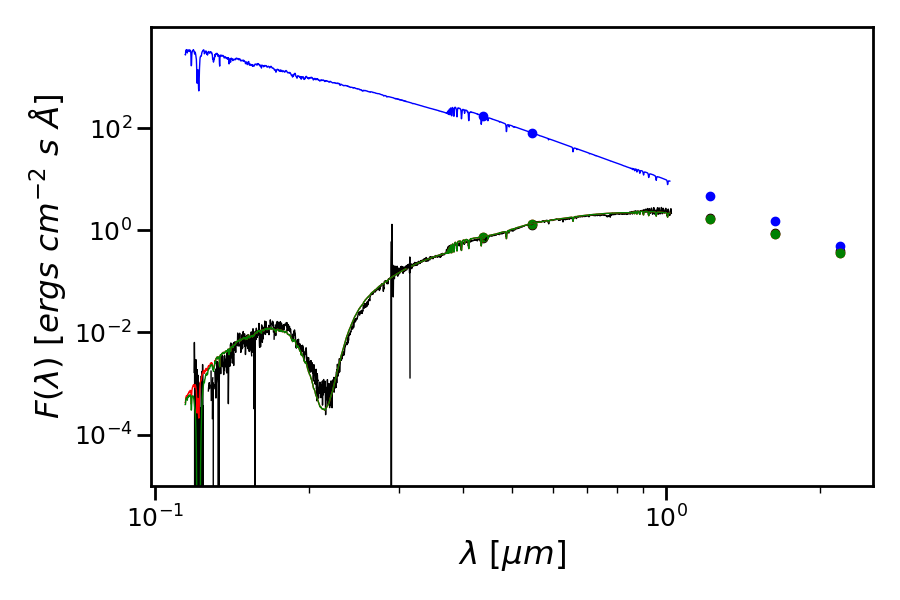

In [18]:
fluxunit = u.erg / ((u.cm ** 2) * u.s * u.angstrom)

norm_model = np.nanmean(hi_ext_modsed["BAND"])
norm_data = np.average(reddened_star.data["BAND"].fluxes)

# plotting setup for easier to read plots
fontsize = 18
font = {"size": fontsize}
mpl.rc("font", **font)
mpl.rc("lines", linewidth=1)
mpl.rc("axes", linewidth=2)
mpl.rc("xtick.major", width=2)
mpl.rc("xtick.minor", width=2)
mpl.rc("ytick.major", width=2)
mpl.rc("ytick.minor", width=2)

# setup the plot
fig, ax = plt.subplots(figsize=(9, 6))

# plot the bands and all spectra for this star
for cspec in modinfo.fluxes.keys():
    if cspec == "BAND":
        ptype = "o"
    else:
        ptype = "-"

    # ax.plot(reddened_star.data[cspec].waves,
    #        weights[cspec], 'k-')

    tflux = reddened_star.data[cspec].fluxes.to(fluxunit, equivalencies=u.spectral_density(reddened_star.data[cspec].waves))
    ax.plot(
        reddened_star.data[cspec].waves,
        tflux / norm_data,
        "k" + ptype,
        label="data",
    )

    # print(reddened_star.data[cspec].waves)
    # print(modinfo.waves[cspec])
    
    ax.plot(
        modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
    )
    ax.plot(
        modinfo.waves[cspec],
        ext_modsed[cspec] / norm_model,
        "r" + ptype,
        label=cspec,
    )
    ax.plot(
        modinfo.waves[cspec],
        hi_ext_modsed[cspec] / norm_model,
        "g" + ptype,
        label=cspec,
    )

# finish configuring the plot
ax.set_ylim(2e0 / norm_model, 2e9 / norm_model)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# ax.legend()

# use the whitespace better
fig.tight_layout()

Create the weight arrays based on the observed uncertainties

In [19]:
# cropping info for weights
#  bad regions are defined as those were we know the models do not work
#  or the data is bad
ex_regions = [
    [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
    [8.7, 10.0],  # bad data from STIS
    [3.55, 3.6],
    [3.80, 3.90],
    [4.15, 4.3],
    [6.4, 6.6],
    [7.1, 7.3],
    [7.45, 7.55],
    [7.65, 7.75],
    [7.9, 7.95],
    [8.05, 8.1],
#     [9.9, 11.0]
] / u.micron

weights = {}
for cspec in data_names:
    weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
    gvals = reddened_star.data[cspec].npts > 0
    weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

    x = 1.0 / reddened_star.data[cspec].waves
    for cexreg in ex_regions:
        weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

# make the photometric bands have higher weight
weights["BAND"] *= 10000.0

# make the bump region higher weight
x = reddened_star.data["STIS"].waves
gvals = np.logical_and(0.205 * u.micron <= x, x < 0.23 * u.micron)
weights["STIS"] *= 100.0

/tmp/ipykernel_14427/302236161.py:23: RuntimeWarning: divide by zero encountered in true_divide
  weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value


Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [20]:
fitinfo = FitInfo(
    pnames,
    plimits,
    weights,
    parameter_priors=ppriors,
    stellar_velocity=velocity,
)

In [21]:
# make sure the initial starting params give reasonable lnprior and lnlike
print(fitinfo.lnprior(params))
print(fitinfo.lnlike(params, reddened_star, modinfo))

0.0
-3880215010.1054134


In [22]:
# simple function to turn the log(likelihood) into the chisqr
#  requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
def nll(*args):
    return -fitinfo.lnprob(*args)

# run the fit
result = op.minimize(
    nll, params, method="Nelder-Mead", options={"maxiter": 1000}, args=(reddened_star, modinfo, fitinfo)
)

# check the fit output
print(result["message"])

Maximum number of iterations has been exceeded.


In [23]:
# save results
params = result["x"]
fit_params = params
params_best = params
pnames_extra = pnames

# print the best fit
for k, val in enumerate(params_best):
    print("{} # {}".format(val, pnames_extra[k]))


4.3487085336421165 # logT
2.4322434337895844 # logg
0.0009179493544245092 # logZ
4.682325744354008 # Av
3.2764754103367153 # Rv
1.4410594456389387 # C2
2.881051617003255 # C3
0.09868255461639014 # C4
4.758501073571324 # x0
0.6000007037223412 # gamma
20.19728253939826 # HI_gal
17.021282031289154 # HI_mw


Calculate and save the extinction curve

In [24]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

print(reddened_star.data.keys())
print(modsed_stardata.data.keys())

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)

print(extdata.exts.keys())

col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save(starname + "_ext.fits", column_info=col_info)

dict_keys(['BAND', 'STIS_Opt', 'STIS'])
dict_keys(['BAND', 'STIS_Opt', 'STIS'])
dict_keys(['BAND', 'STIS', 'STIS_Opt'])


Plot the spectra

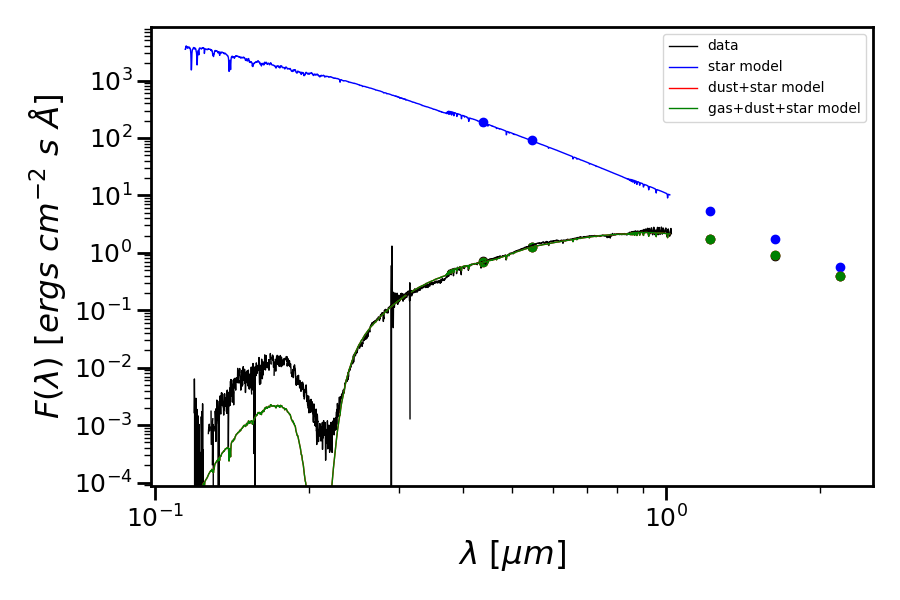

In [25]:
%matplotlib widget

norm_model = np.average(hi_ext_modsed["BAND"])
norm_data = np.average(reddened_star.data["BAND"].fluxes)

# plotting setup for easier to read plots
fontsize = 18
font = {"size": fontsize}
mpl.rc("font", **font)
mpl.rc("lines", linewidth=1)
mpl.rc("axes", linewidth=2)
mpl.rc("xtick.major", width=2)
mpl.rc("xtick.minor", width=2)
mpl.rc("ytick.major", width=2)
mpl.rc("ytick.minor", width=2)

# setup the plot
fig, ax = plt.subplots(figsize=(9, 6))

# plot the bands and all spectra for this star
for cspec in modinfo.fluxes.keys():
    if cspec == "BAND":
        ptype = "o"
    else:
        ptype = "-"

    # ax.plot(reddened_star.data[cspec].waves,
    #        weights[cspec], 'k-')

    if cspec == "STIS":
        dlabel = "data"
        mlabel = "star model"
        mlabel2 = "dust+star model"
        mlabel3 = "gas+dust+star model"
    else:
        dlabel = None
        mlabel = None
        mlabel2 = None
        mlabel3 = None

    ax.plot(
        reddened_star.data[cspec].waves,
        reddened_star.data[cspec].fluxes / norm_data,
        "k" + ptype,
        label=dlabel,
    )

    # print(reddened_star.data[cspec].waves)
    # print(modinfo.waves[cspec])

    ax.plot(
        modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=mlabel
    )
    ax.plot(
        modinfo.waves[cspec],
        ext_modsed[cspec] / norm_model,
        "r" + ptype,
        label=mlabel2,
    )
    ax.plot(
        modinfo.waves[cspec],
        hi_ext_modsed[cspec] / norm_model,
        "g" + ptype,
        label=mlabel3,
    )

# finish configuring the plot
ax.set_ylim(2e1 / norm_model, 2e9 / norm_model)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

ax.legend(fontsize=10)

# use the whitespace better
fig.tight_layout()
plt.show()

Plot the extinction curve

False


/home/kgordon/Python/measure_extinction/measure_extinction/extdata.py:668: UserWarning: attempt to normalize a non E(lambda-V) curve with A(V)
  warnings.warn(


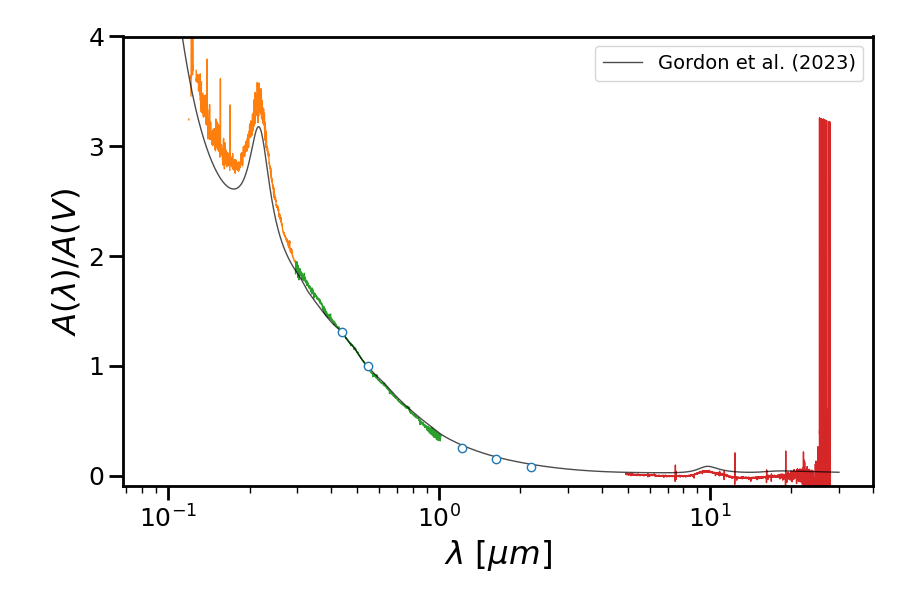

In [24]:
fig, ax = plt.subplots(figsize=(9, 6))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
extdata.trans_elv_alav()

extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylim(0.0, 10.0)
ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.logspace(np.log10(0.0912), np.log10(30.0), num=1000) * u.micron
#smcbar = G03_SMCBar()
#ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")

g23_rv31 = G23(Rv=3.1)
ax.plot(mod_x, g23_rv31(mod_x), "k-", alpha=0.7, label="Gordon et al. (2023)")

ax.set_ylim(-0.1, 4.0)

ax.legend(fontsize=14)
fig.tight_layout()

Run emcee MCMC sampler to define uncertainties (bonus section)

In [19]:
p0 = params
ndim = len(p0)

#nwalkers = 2 * ndim
#nsteps = 50
#burn = 50

nwalkers = 100
nsteps = 500
burn = 500

# setting up the walkers to start "near" the inital guess
p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

# setup the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo, fitinfo)
)

# burn in the walkers
pos, prob, state = sampler.run_mcmc(p, burn)

# rest the sampler
sampler.reset()

# do the full sampling
pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)

# create the samples variable for later use
samples = sampler.chain.reshape((-1, ndim))

# get the best fit values
pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
params_best = get_best_fit_params(sampler)
fit_params = params_best
print("best params")
print(params_best)

# get the 16, 50, and 84 percentiles
params_per = get_percentile_params(samples)

# save the best fit and p50 +/- uncs values to a file
# save as a single row table to provide a uniform format
#f = open(out_basename + "_fit_params.dat", "w")
#f.write("# best fit, p50, +unc, -unc\n")
for k, val in enumerate(params_per):
    print(
        "{} {} {} {} # {}".format(
            params_best[k], val[0], val[1], val[2], pnames_extra[k]
        )
    )
#    f.write(
#        "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#        )
#    )


/home/kgordon/Bin/miniconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


emcee: Exception while calling your likelihood function:
  params: [ 4.44165185  3.09982188  1.04383165  4.7580101   2.89187526  1.04080708
  2.65847416  0.10497987  4.86323332  0.84393506 23.01919307 21.33129781]
  args: (<measure_extinction.stardata.StarData object at 0x7f69076c68e0>, <measure_extinction.modeldata.ModelData object at 0x7f6906f06370>, <measure_extinction.utils.fit_model.FitInfo object at 0x7f6906e4f9d0>)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/kgordon/Bin/miniconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/kgordon/Python/measure_extinction/measure_extinction/utils/fit_model.py", line 167, in lnprob
    return lnp + fitinfo.lnlike(params, obsdata, modeldata)
  File "/home/kgordon/Python/measure_extinction/measure_extinction/utils/fit_model.py", line 87, in lnlike
    ext_modsed = modeldata.dust_extinguished_sed(
  File "/home/kgordon/Python/measure_extinction/measure_extinction/modeldata.py", line 241, in dust_extinguished_sed
    axav = g23mod(shifted_waves)
  File "/home/kgordon/Bin/miniconda3/lib/python3.9/site-packages/astropy/modeling/core.py", line 424, in __call__
    new_call = make_function_with_signature(
  File "/home/kgordon/Bin/miniconda3/lib/python3.9/site-packages/astropy/modeling/core.py", line 401, in __call__
    return super(cls, self).__call__(*inputs, **kwargs)
  File

KeyboardInterrupt: 

In [ ]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save(starname + "_ext.fits", column_info=col_info)

In [ ]:
norm_model = np.average(hi_ext_modsed["BAND"])
norm_data = np.average(reddened_star.data["BAND"].fluxes)

# plotting setup for easier to read plots
fontsize = 18
font = {"size": fontsize}
mpl.rc("font", **font)
mpl.rc("lines", linewidth=1)
mpl.rc("axes", linewidth=2)
mpl.rc("xtick.major", width=2)
mpl.rc("xtick.minor", width=2)
mpl.rc("ytick.major", width=2)
mpl.rc("ytick.minor", width=2)

# setup the plot
fig, ax = plt.subplots(figsize=(13, 10))

# plot the bands and all spectra for this star
for cspec in modinfo.fluxes.keys():
    if cspec == "BAND":
        ptype = "o"
    else:
        ptype = "-"

    # ax.plot(reddened_star.data[cspec].waves,
    #        weights[cspec], 'k-')

    ax.plot(
        reddened_star.data[cspec].waves,
        reddened_star.data[cspec].fluxes / norm_data,
        "k" + ptype,
        label="data",
    )

    # print(reddened_star.data[cspec].waves)
    # print(modinfo.waves[cspec])

    ax.plot(
        modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
    )
    ax.plot(
        modinfo.waves[cspec],
        ext_modsed[cspec] / norm_model,
        "r" + ptype,
        label=cspec,
    )
    ax.plot(
        modinfo.waves[cspec],
        hi_ext_modsed[cspec] / norm_model,
        "g" + ptype,
        label=cspec,
    )

# finish configuring the plot
ax.set_ylim(8e4 / norm_model, 2e9 / norm_model)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# ax.legend()

# use the whitespace better
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
extdata.trans_elv_alav()

extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylim(0.0, 10.0)
ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")

f19_rv31 = F19(Rv=3.1)
ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")